In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
# random.seed(0)

%matplotlib inline

In [2]:
# Convolutional Neural Network
# keras functional API
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
# hyperparameter
imheight = 128
imwidth = 128
channels = 3
# ALPHA = 0.2
ALPHA=0.05

In [20]:
# shared Layer 
shared_Conv1= Conv2D(32, (4,4), padding='same', activation='relu')
shared_MP1= MaxPooling2D(pool_size=(2, 2))

In [21]:
def create_embNet():
    some_input = Input(shape=(imwidth, imheight, channels))
    conv1 = shared_Conv1(some_input)
    pool1 = shared_MP1(conv1)
    conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    flatten = Flatten()(pool2)
    dense_layer = Dense(10, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    return Model(inputs=[some_input], outputs=norm_layer)

In [22]:
# define three Inputs
a_in = Input(shape = (imheight, imwidth, channels), name='anchor_input')
p_in = Input(shape = (imheight, imwidth, channels), name='positive_input')
n_in = Input(shape = (imheight, imwidth, channels), name='negative_input')

In [23]:
# for embedding
embNet_a = create_embNet()
embNet_p = create_embNet()
embNet_n = create_embNet()

a_emb = embNet_a(a_in)
p_emb = embNet_p(p_in)
n_emb = embNet_n(n_in)

In [24]:
# for embedding
# the case of using same params
embNet = create_embNet()
a_emb = embNet(a_in)
p_emb = embNet(p_in)
n_emb = embNet(n_in)

In [25]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [26]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=ALPHA, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

### Load data and resize

In [11]:
data = np.load('./np_datasets/Blouse/blouse_pad_triplets.npy')

In [12]:
data.shape

(1290, 3)

(161, 161, 3) <class 'numpy.ndarray'>


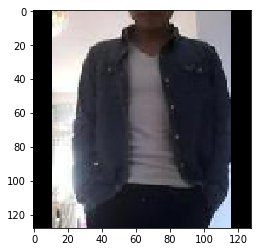

In [13]:
target = data[0][0]*255
print(target.shape,type(target))
pilImg = Image.fromarray(np.uint8(target))
plt.imshow(pilImg.resize((128,128)))
plt.show()

In [16]:
import numpy as np
triplets_ = []
# triplets = np.ndarray
for triplet in data:
    
    anc_img = Image.fromarray(np.uint8(triplet[0])).convert('RGB')
    pos_img = Image.fromarray(np.uint8(triplet[1])).convert('RGB')
    neg_img = Image.fromarray(np.uint8(triplet[2])).convert('RGB')
    
    anc_img = np.array(anc_img.resize((128,128)))
    pos_img = np.array(pos_img.resize((128,128)))    
    neg_img = np.array(neg_img.resize((128,128)))    
    
    tri = [anc_img,pos_img,neg_img]
    triplets_.append(np.array(tri))

triplets = np.array(triplets_)    

## Have to order the size

In [27]:
triplets.shape

(1290, 3, 128, 128, 3)

In [28]:
# compile model
tripletNet.compile(loss=None, optimizer='adam')

# fit model
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, batch_size=100) # using batch_size is better
tripletNet.save('./np_datasets/Blouse/blouseTriplet.h5')

# save partial Network 
embNet_a.save('./np_datasets/Blouse/blouse_embNet_a.h5')
embNet_p.save('./np_datasets/Blouse/blouse_embNet_p.h5')
embNet_n.save('./np_datasets/Blouse/blouse_embNet_n.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  


Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[100,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: model_9_1/conv2d_10/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/AddN_9"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_9_1/conv2d_10/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_10/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training/Adam/gradients/model_9_2/flatten_8/Reshape_grad/Shape/_175 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_87_training/Adam/gradients/model_9_2/flatten_8/Reshape_grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'model_9_1/conv2d_10/convolution', defined at:
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-56c36262f4c4>", line 5, in <module>
    p_emb = embNet(p_in)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3189, in conv2d
    data_format=tf_data_format)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: model_9_1/conv2d_10/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/AddN_9"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_9_1/conv2d_10/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_10/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training/Adam/gradients/model_9_2/flatten_8/Reshape_grad/Shape/_175 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_87_training/Adam/gradients/model_9_2/flatten_8/Reshape_grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [16]:
triplets = np.load('./np_datasets/Blouse/blouse_triplets.npy')


In [20]:
triplets.shape

(1290, 3)